# Model V2
The 8 indicators being used are NDVI, rainfall, land surface temperature, soil moisture 10/40/200 cm, ndwi, and evi
### About the Data 
 - Each indicator is a mean value from June 20 to November 1 (the estimated growing season)
 - Image collections are not filtered for cloudiness upon data collection; this leaves chance for obscured numbers 
 - Years are from 2000 to 2020
 - The crop yield data is only for maize 
 - I control naming conventions of data from GEE, if needed I can go back and download it again
 - NDVI is a 16 day average and is prefiltered for clear images

 ### Improvements
  
TIME (2): optimize time frame to frame when indicators most impact yields
 - adjust time frame
 - maybe use subset of data, an individual year, and figure out which months are best 
 - stratify by month to figure out which months are most important 
  
CROP DATA (3)
 - add dummy variable for crop
 - standardize crop yield -- group by crop (.groupby('crop').mean()/std() to get each mean/std)
 - crop masking algorithm (4) -- only export data from areas with crops

REGRESSIONS (5)
 - using lasso, elastic net, and ridge (maybe)

In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import dump, load
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [18]:
################## Functions For Cleaning ##################
def create_dict(dir, dict):
    '''Params dir and dict are the directory name and dictionary to store dataframes in'''
    for filename in os.listdir(dir):
        fpath = os.path.join(dir, filename)         # creates the file path name
        if os.path.isfile(fpath):                   # make sure the file is real
            year = filename[:4]                     # year is at index 0-3 in filename
            dict[int(year)] = pd.read_csv(fpath)    # input dictionary now has key of year and value of df for that year

def reorder(dict):
    sorted_keys = sorted(list(dict.keys()))
    sorted_dict = {i: dict[i] for i in sorted_keys}
    return sorted_dict

def clean_dfs(dict, indicator):
    '''dict is dictionary of dfs to clean, indicator is name value column of each df. This can
    be found in the mean_ columns above. Last line sets index to district name to make 
    concat all dfs easier.'''
    for k, v in dict.items():
        year = k
        v.drop(columns=['system:index', '.geo'], inplace=True)
        v.rename({f'mean_{indicator}': f'{indicator}'+str(year)}, axis=1, inplace=True)
        v.set_index(['district_name'], inplace=True)

################## Uploading Files ##################
# name directories in file path 
ndvi_dir = 'mean_ndvi'
lst_dir = 'mean_lst'
rain_dir = 'mean_rainfall'
sm_10_dir = 'mean_soil_moisture_10cm'
sm_40_dir = 'mean_soil_moisture_40cm'
sm_200_dir = 'mean_soil_moisture_200cm'
ndwi_dir = 'mean_ndwi'
evi_dir = 'mean_evi'
# create dictionaries to store each individual df
ndvi_dict = {}
lst_dict = {}
rain_dict = {}
sm_10_dict = {}
sm_40_dict = {}
sm_200_dict = {}
ndwi_dict = {}
evi_dict = {}

yields = pd.read_excel('/Users/gavmross/Desktop/School/cua_spring_23/ghana/MOFA_YieldData_Maize.xlsx')
key = pd.read_excel("/Users/gavmross/Desktop/School/cua_spring_23/ghana/DistrictKey.xlsx")

################## Cleaning Indicator Data ##################
# create dictionaries with k:v = year:dataframe of that year/indicator
create_dict(ndvi_dir, ndvi_dict)
create_dict(lst_dir, lst_dict)
create_dict(rain_dir, rain_dict)
create_dict(sm_10_dir, sm_10_dict)
create_dict(sm_40_dir, sm_40_dict)
create_dict(sm_200_dir, sm_200_dict)
create_dict(ndwi_dir, ndwi_dict)
create_dict(evi_dir, evi_dict)

# reorder dict keys chronologically 
ndvi_dict = reorder(ndvi_dict)
lst_dict = reorder(lst_dict)
rain_dict = reorder(rain_dict)
sm_10_dict = reorder(sm_10_dict)
sm_40_dict = reorder(sm_40_dict)
sm_200_dict = reorder(sm_200_dict)
ndwi_dict = reorder(ndwi_dict)
evi_dict = reorder(evi_dict)

# clean dfs
clean_dfs(ndvi_dict, 'ndvi')
clean_dfs(lst_dict, 'lst')
clean_dfs(rain_dict, 'rain')
clean_dfs(sm_10_dict, 'soil_moisture_10cm')
clean_dfs(sm_40_dict, 'soil_moisture_40cm')
clean_dfs(sm_200_dict, 'soil_moisture_200cm')
clean_dfs(ndwi_dict, 'ndwi')
clean_dfs(evi_dict, 'evi')

# create one dataframe for each indicator
ndvi_df = pd.concat(ndvi_dict.values(), axis=1)
lst_df = pd.concat(lst_dict.values(), axis=1)
rain_df = pd.concat(rain_dict.values(), axis=1)
sm_10_df = pd.concat(sm_10_dict.values(), axis=1)
sm_40_df = pd.concat(sm_40_dict.values(), axis=1)
sm_200_df = pd.concat(sm_200_dict.values(), axis=1)
ndwi_df = pd.concat(ndwi_dict.values(), axis=1)
evi_df = pd.concat(evi_dict.values(), axis=1)

# drop Tempane because it is not included in Yield data
rain_df.drop("Tempane", inplace=True)
ndvi_df.drop("Tempane", inplace=True)
lst_df.drop("Tempane", inplace=True)
sm_10_df.drop("Tempane", inplace=True)
sm_40_df.drop("Tempane", inplace=True)
sm_200_df.drop("Tempane", inplace=True)
ndwi_df.drop("Tempane", inplace=True)
evi_df.drop("Tempane", inplace=True)

# turn dfs from wide to long format
ndvi_df.reset_index(inplace=True)
ndvi_final = pd.wide_to_long(ndvi_df, 'ndvi', 'district_name', 'year')
lst_df.reset_index(inplace=True)
lst_final = pd.wide_to_long(lst_df, 'lst', 'district_name', 'year')
rain_df.reset_index(inplace=True)
rain_final = pd.wide_to_long(rain_df, 'rain', 'district_name', 'year')
sm_10_df.reset_index(inplace=True)
sm10_final = pd.wide_to_long(sm_10_df, 'soil_moisture_10cm', 'district_name', 'year')
sm_40_df.reset_index(inplace=True)
sm40_final = pd.wide_to_long(sm_40_df, 'soil_moisture_40cm', 'district_name', 'year')
sm_200_df.reset_index(inplace=True)
sm200_final = pd.wide_to_long(sm_200_df, 'soil_moisture_200cm', 'district_name', 'year')
ndwi_df.reset_index(inplace=True)
ndwi_final = pd.wide_to_long(ndwi_df, 'ndwi', 'district_name', 'year')
evi_df.reset_index(inplace=True)
evi_final = pd.wide_to_long(evi_df, 'evi', 'district_name', 'year')

# merge indicators dfs into one df 
indic_df = ndvi_final.join([lst_final, rain_final, sm10_final, sm40_final, sm200_final, ndwi_final, evi_final])

################## Cleaning Yield Data ##################
# drop district in yield data not in indicator data
yields = yields[yields['DistID'] !=38]

# rename key columns
key.rename({"Dist": "District ID", 'Unnamed: 1': "District Name"}, inplace=True, axis=1)

#create mapper for district ID and district naem
mapper = dict(zip(key['District ID'], key['District Name']))

# map district name to district ID
yields['DistName'] = yields['DistID'].map(mapper)
yields = yields[['DistID', 'DistName', 'Year', 'Yield', 'Crop']]        # reorder columns
yields.drop(['Crop', 'DistID'], axis=1, inplace=True)                   # once i have mapped names, do not need ID anymore

# sort by year then name to get it in same format as indicator df
yields_sort = yields.sort_values(by=['Year', 'DistName'])
# rename to have same naming conventions as other dfs
yields_final = yields_sort.rename({'DistName': 'district_name', 'Year': 'year', 'Yield': 'yield'}, axis=1)

# final df is only 2000 to 2020
yields_final = yields_final.loc[(yields_final['year'] > 1999) & (yields_final['year'] < 2021)]
yields_final.reset_index(inplace=True, drop=True)

################## Combine Indicator and Yield Data ##################
# rest index first to order it properly 
indic_df.reset_index(inplace=True)
# strip all space from district names to make naming convention same as yield data
indic_df['district_name'] = indic_df['district_name'].str.replace(' ', '')
# sort by year and district name to make it same as yield 
indic_final = indic_df.sort_values(by=['year', 'district_name'])
# reset indices so merging can take place
yields_final.reset_index(drop=True, inplace=True)
indic_final.reset_index(drop=True, inplace=True)

# create a dictionary that is k:v = indic_names:yields_names for comparison purposes 
# save indicator and yield data district names to compare
indic_names = indic_final['district_name'].unique()
yields_names = yields_final['district_name'].unique()
# turn dict into df for filtering purposes (could just turn series into df)
name_dict = dict(zip(indic_names, yields_names))
name_df = pd.DataFrame.from_dict(name_dict, orient='index')
name_df.reset_index(inplace=True)
name_df.columns=['indic', 'yield']
name_df.loc[name_df['indic'] != name_df['yield']]                       # filter for names that do not match 

# add yield col into indicator df
indic_final['yield'] = yields_final['yield']
indic_final

################## Prep Data for Model ##################
# rename to model df
model_df = indic_final
#sns.pairplot(model_df)

# cannot have NAs in ML model, for now just going to drop it but can come up with better solution
model_df.isna().sum()
# drop rows with na in them, lost 153 rows 
model_df.dropna(axis=0, how='any', inplace=True)
model_df.head()

,district_name,year,ndvi,lst,rain,soil_moisture_10cm,soil_moisture_40cm,soil_moisture_200cm,ndwi,evi,yield
0,Bawku,2000,4414.133649,15533.286044,4.807214,0.347874,0.354726,0.351588,0.026860,0.321506,1.5
1,BawkuWest,2000,5627.316414,15478.890897,4.839396,0.355468,0.361063,0.359270,0.110894,0.387941,2.0
3,Bole,2000,5094.237214,15295.688814,4.204937,0.324574,0.319083,0.332412,0.174509,0.418412,1.0
4,Bolgatanga,2000,6031.486869,15436.132054,4.479659,0.349717,0.356823,0.360590,0.124552,0.405353,0.6
5,Bongo,2000,5204.888441,15489.788024,4.285092,0.341043,0.349102,0.351035,0.080824,0.357974,0.6


In [19]:
################## Regression with Cross Validate Holdout ##################
# not using district name because it is categorical
X = model_df.drop(['yield', 'district_name'], axis=1)
Y = model_df['yield']

# create training and holdout
X_train, X_holdout, Y_train, Y_holdout = train_test_split(X, Y, test_size=.1, random_state=101) # test size is smaller because it is holdout

# for loop to iterate over polynomial complexity 
rmse_dict = {}

for i in range(1, 7):
    # create polynomial converter for degree in for loop 
    poly_convert = PolynomialFeatures(degree=1, include_bias=False)
    # convert X_train into polynomial variables 
    poly_X_train = poly_convert.fit_transform(X_train)
    # create model 
    model = LinearRegression(fit_intercept=True)
    # create scores used in cross validation
    scores = cross_val_score(model, poly_X_train, Y_train, scoring='neg_mean_squared_error', cv=10)
    # store performance metric 
    RMSE = np.sqrt(abs(scores).mean())
    rmse_dict[i] = RMSE

print("Lowest test RMSE Complexity Level: ", min(rmse_dict, key=rmse_dict.get))
print("Corresponding lowest test RMSE: ", min(rmse_dict.values()))

Lowest test RMSE Complexity Level:  1
Corresponding lowest test RMSE:  0.521224373299636


In [20]:
################## Final Model: Linear ##################
# do not need polynomial converter cause best model is linear 
model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train)

# predict using holdout indpendent variables and compare Yhat with Yholdout 
Yhat_holdout = model.predict(X_holdout)

RMSE = np.sqrt(mean_squared_error(Y_holdout, Yhat_holdout))
print("RMSE: ", RMSE)
print("RMSE as Percent of Holdout Std: ", RMSE/Y_holdout.std())

RMSE:  0.7817478316867357
RMSE as Percent of Holdout Std:  0.8987475897270777


In [21]:
################## Output Regression Results ##################
model_sm = sm.OLS(endog=Y, exog=sm.add_constant(X)).fit()
table = Stargazer([model_sm])
table

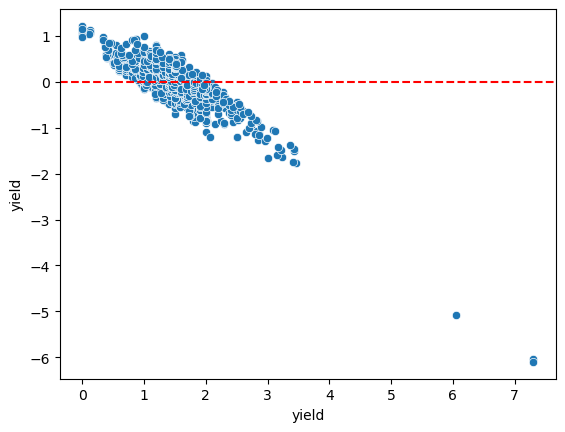

In [22]:
################## Analyze Residuals ##################
Yhat_resid = model.predict(X)
residuals = Yhat_resid-Y
sns.scatterplot(x=Y, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')